In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch
import scipy.stats as stats
import hist
import mplhep as hep
plt.style.use(hep.style.CMS)

# Set defaults

In [16]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
# chip_names = ["ET2_CNM_B1_3_HV210","ET2_CNM_B2_6_HV140"]
chip_names = ["ET2_CNM_B1_3_HV210","ET2_EPIR_B1_1_HV30"]
# chip_names = ["ET2-W36-IP5-20", "ET2-W36-IP7-13", "ET2-W36-IP7-10"]
# old 
# chip_names = ["ET2-W36-IP7-12", "ET2-W36-IP5-15", "ET2-W36-IP5-14"]
# old [0x78, 0x61, 0x74]
# old top modified C type =  ET2-W36-IP5-15
# replaced with new type D = ET2-W36-IP7-10
chip_fignames = chip_names
chip_figtitles = ["ETROC2 BumpBonded FFF 210V", "ETROC2 BumpBonded FFF 30V"]

# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
# chip_addresses = [0x60, 0x61]
chip_addresses = [0x60, 0x62]
# chip_addresses = [0x78, 0x74, 0x61]
ws_addresses = [None, None, None]

today = datetime.date.today().isoformat()
# today = "2023-09-08"


# i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
# i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
# #i2c_gui.__no_connect_type__ = "check"  # default behaviour

hostname = "192.168.2.3"

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (today + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# Make i2c_connection class object

In [17]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses,chip_names,[("1","1"), ("1","1"), ("1","1")])

# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [18]:
# 0 - 0 - (disable & auto_cal all pixels) - (auto_TH_CAL) - (disable default all pixels) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00100111')

Passed pixel check for chip: 0x60
Passed peripheral write check for chip: 0x60
Peripherals set for chip: 0x60
Disabled pixels for chip: 0x60


Calibrating and Disabling row: 100%|██████████| 16/16 [02:16<00:00,  8.50s/it]


Auto calibration and Disable Pixel operations finished for chip: 0x60
Passed pixel check for chip: 0x62
Passed peripheral write check for chip: 0x62
Peripherals set for chip: 0x62
Disabled pixels for chip: 0x62


Calibrating and Disabling row: 100%|██████████| 16/16 [02:16<00:00,  8.51s/it]

Auto calibration and Disable Pixel operations finished for chip: 0x62


## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

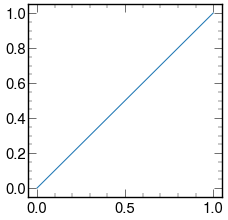

In [14]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(dpi=50, figsize=(5,5))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.plot([1, 0], [1, 0])
plt.show()
plt.close()

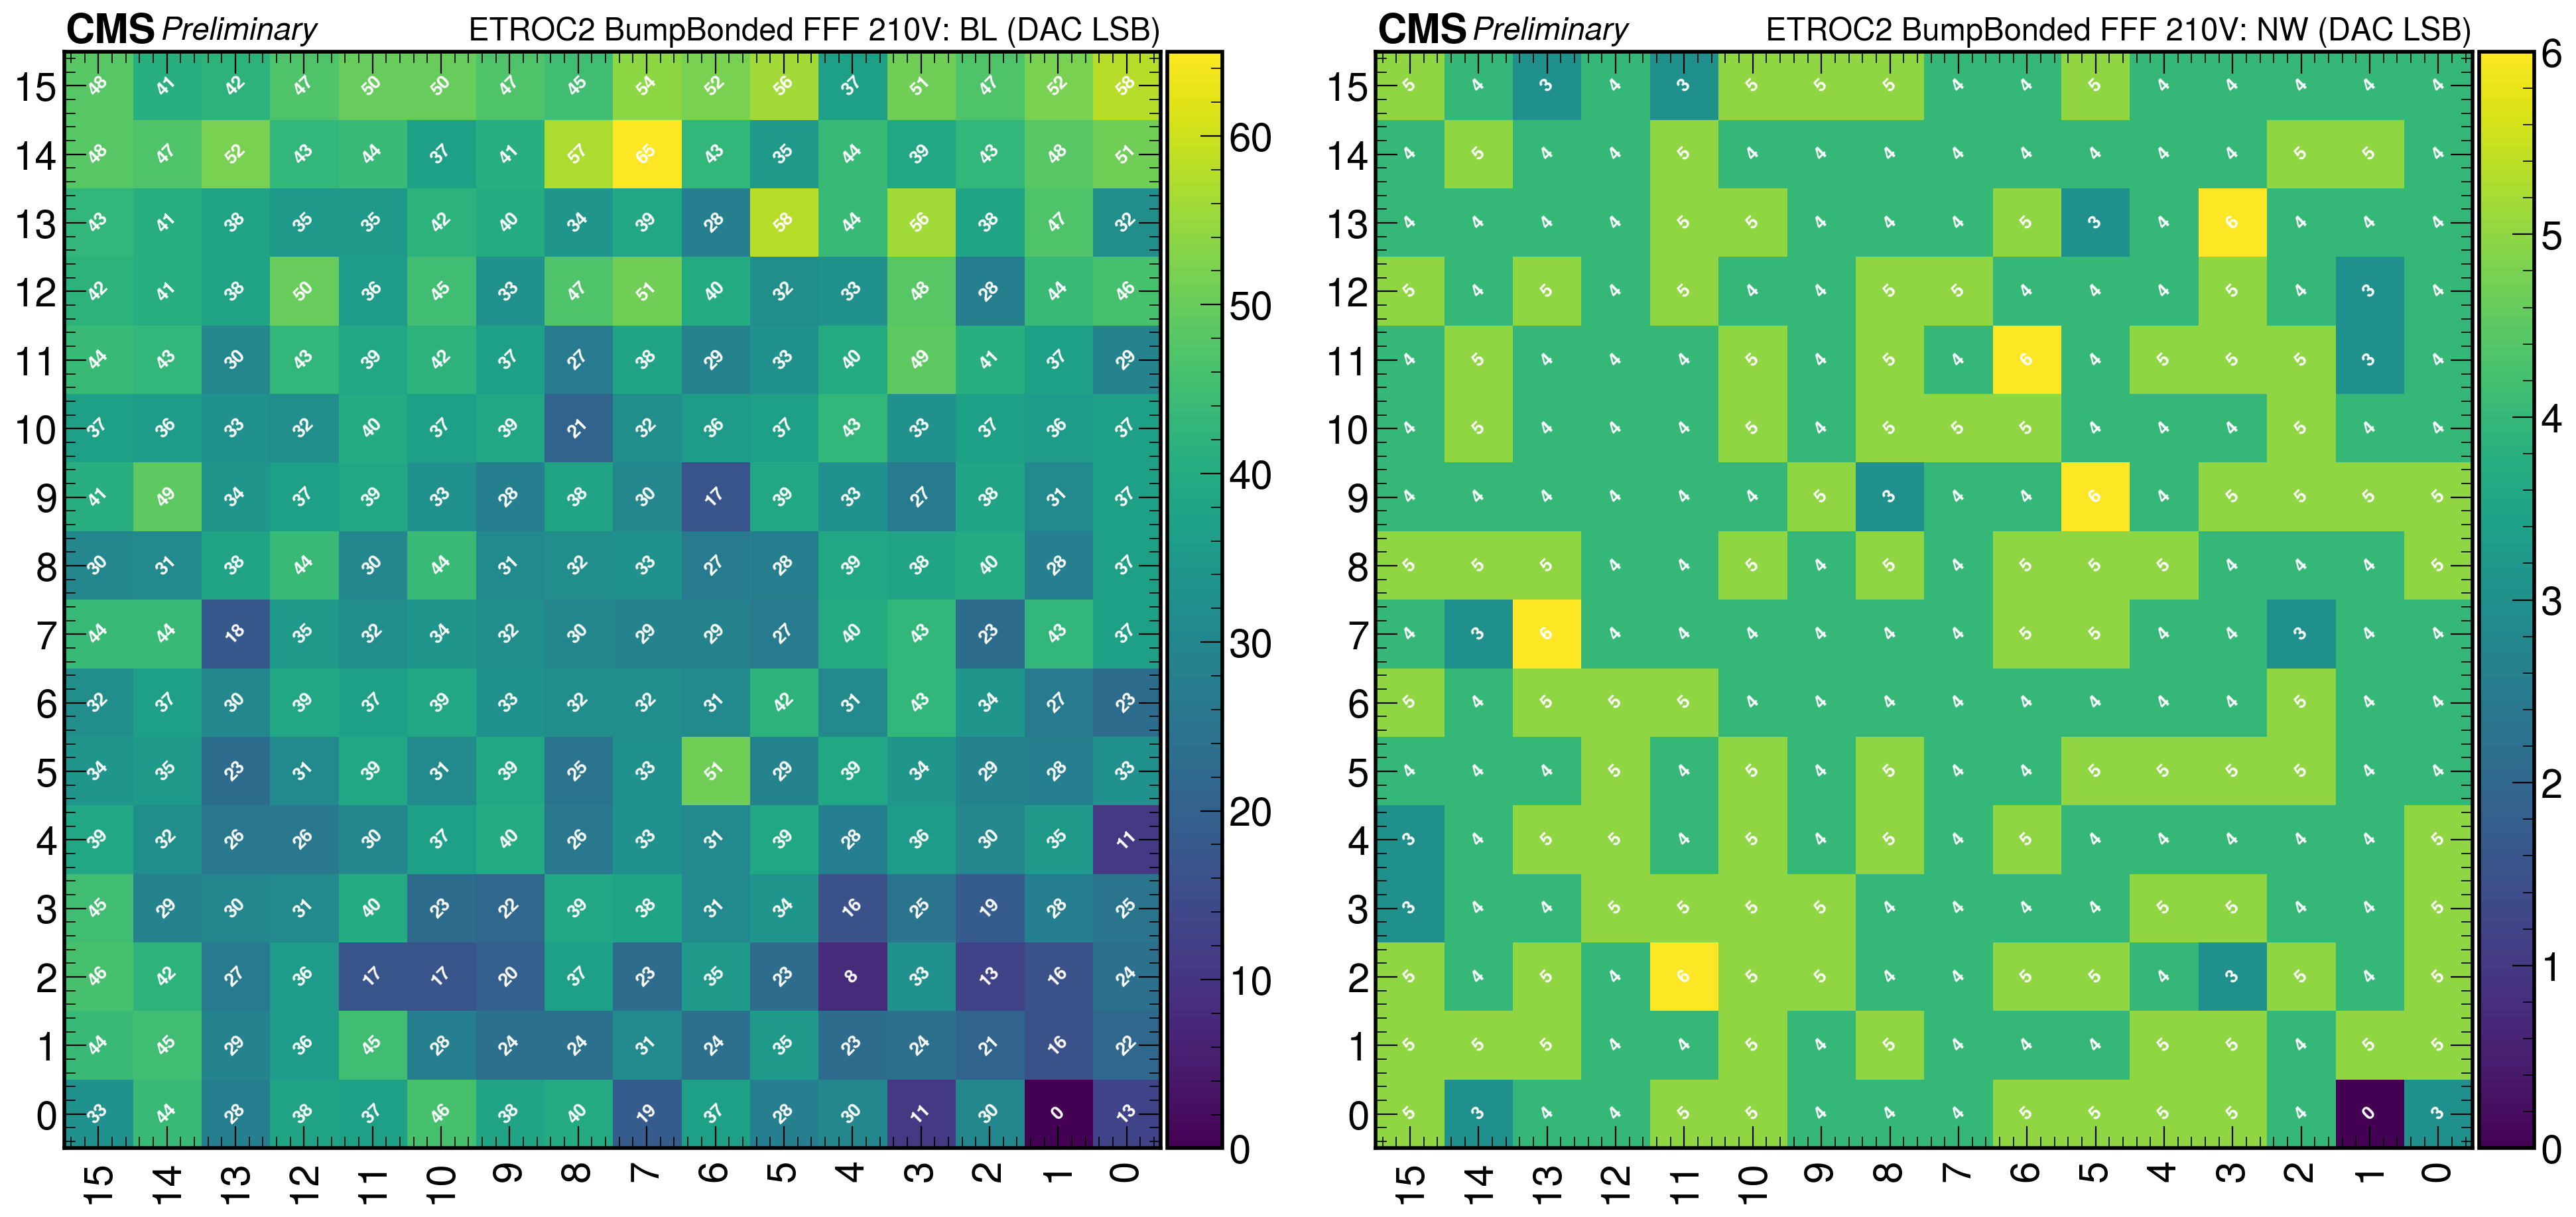

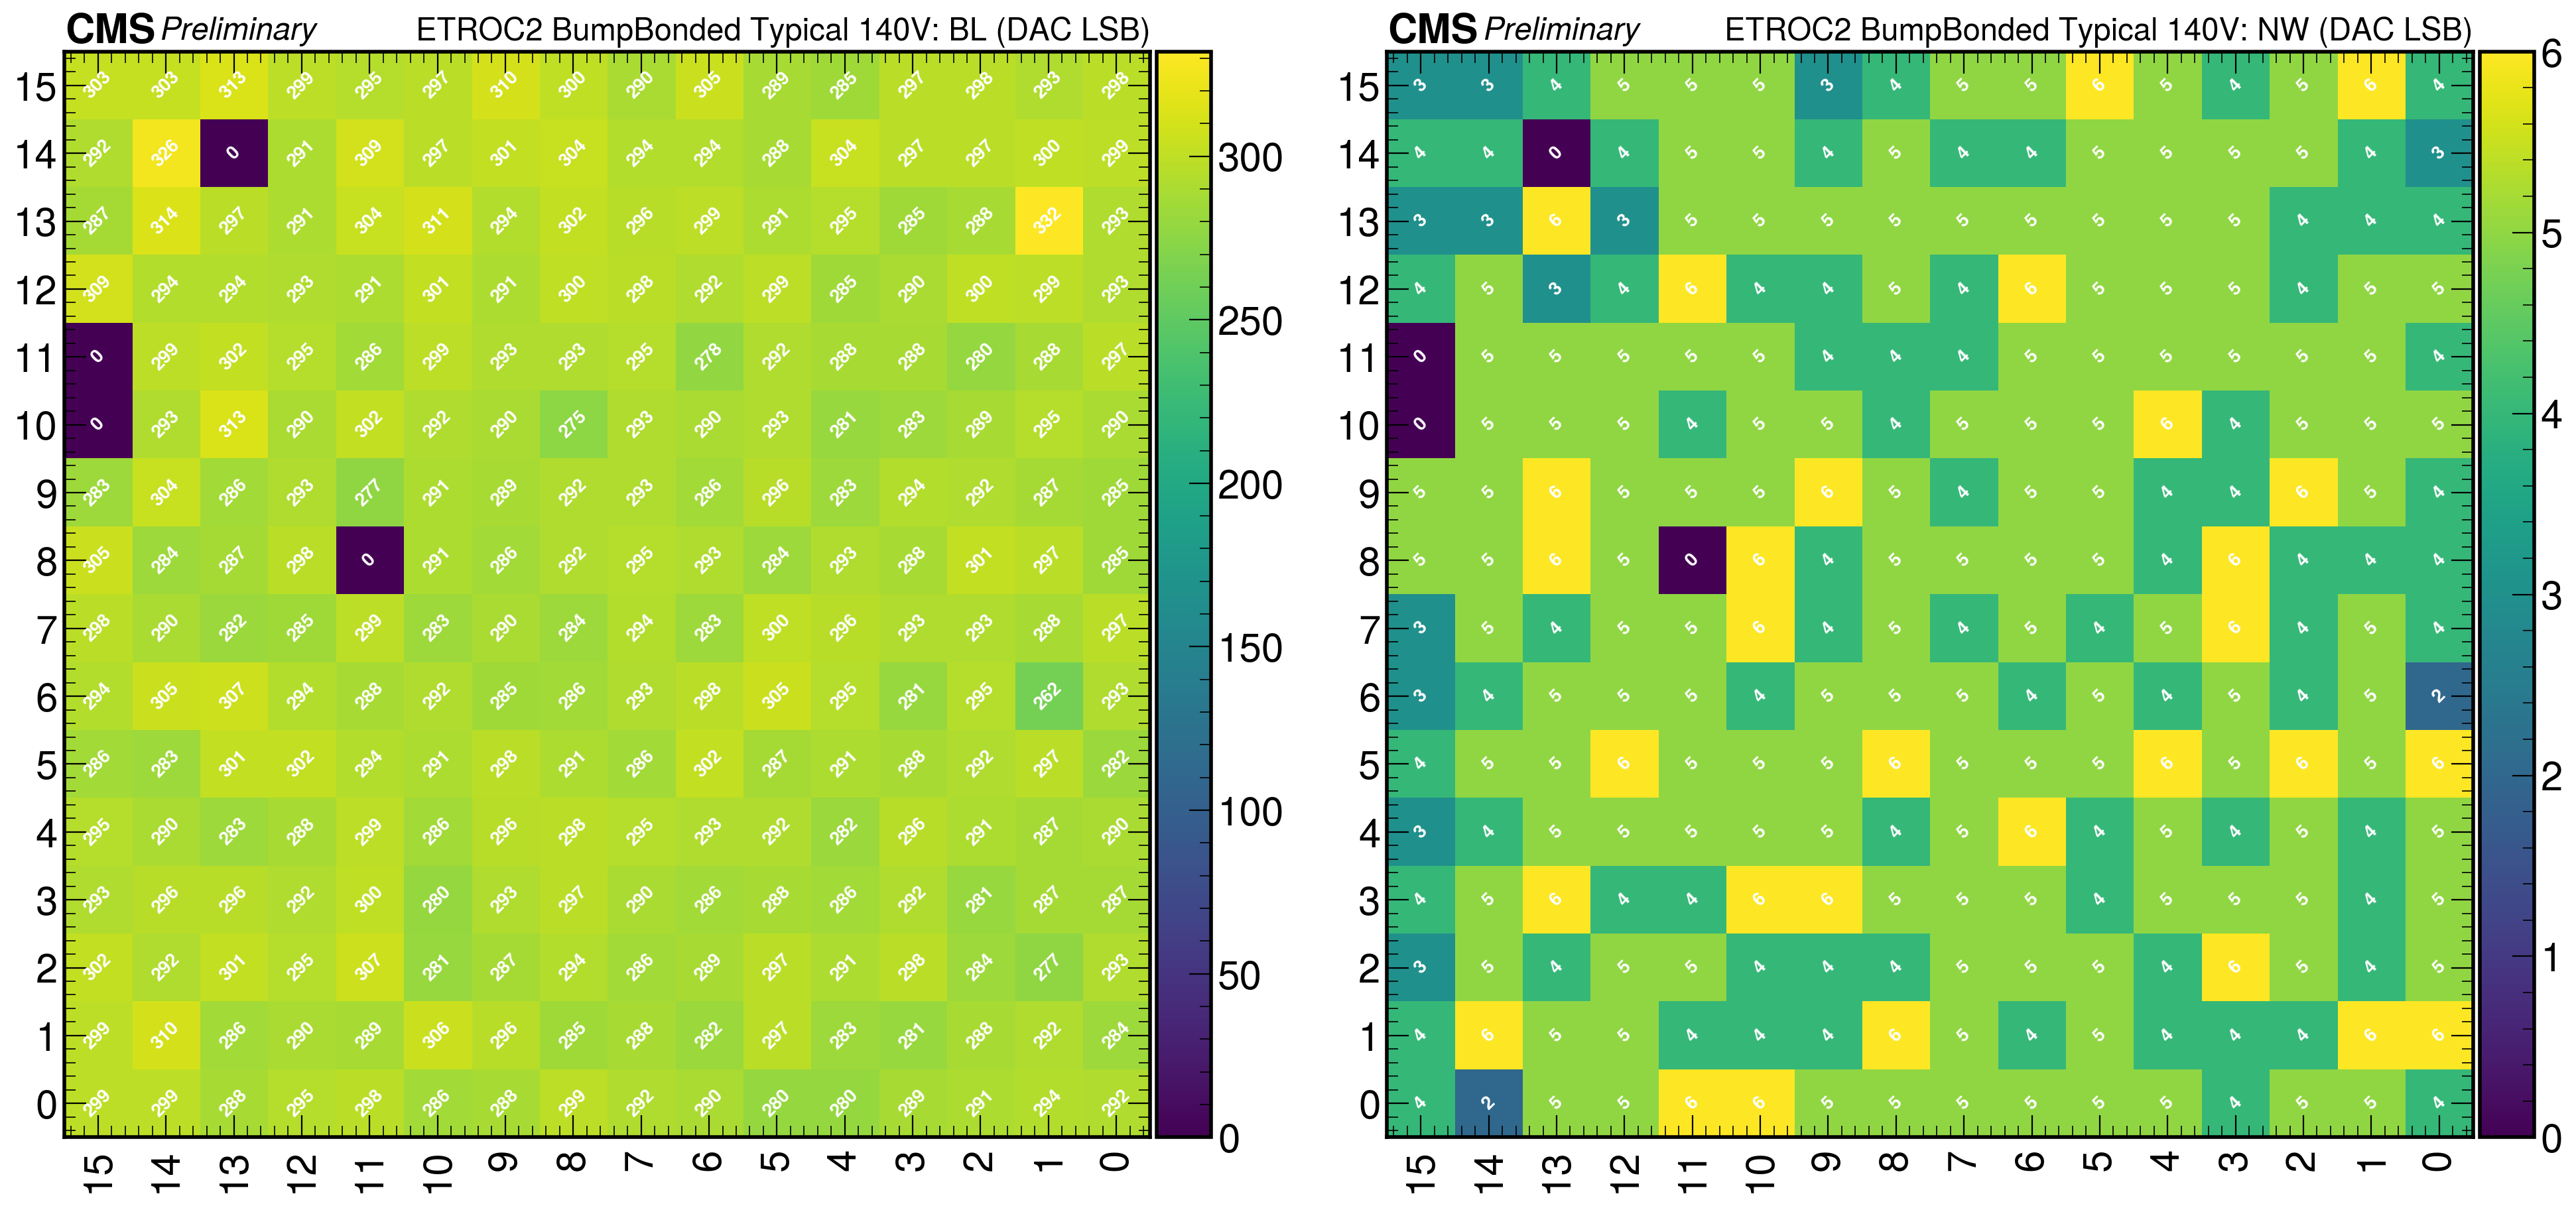

In [15]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_figtitles):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(20,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.show()

### Save BL and NW to be loaded later

In [ ]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.save_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.save_auto_cal_NW_map(chip_address, chip_name, "")

In [ ]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.load_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.load_auto_cal_NW_map(chip_address, chip_name, "")

# Define pixels of interest

In [ ]:
# row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]
# row_list = [15, 15, 15, 15]
# col_list = [6, 7, 8, 9]
# row_list = [15, 15]
# col_list = [6, 9]
# row_list = [14, 14, 15, 15]
# col_list = [7, 8, 7, 8]
# row_list = [14, 14, 14, 14, 15, 15, 15, 15]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9]
# row_list = [14, 15]
# col_list = [6, 6]
row_list = [14, 14]
col_list = [6, 9]
# row_list = [0, 0, 0]
# col_list = [14, 15, 13]

scan_list = list(zip(row_list, col_list))
print(scan_list)

### Enable pixels of Interest

In [ ]:
i2c_conn.enable_select_pixels_in_chips(scan_list)

In [ ]:
offset = 0x19
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

### Disable Pixels of Interest

In [ ]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row,col in scan_list:
        i2c_conn.disable_pixel(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

### Calibrate Pixels of Interest

In [ ]:
for chip_address,chip_name in zip(chip_addresses,chip_names):
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row,col in scan_list:
        i2c_conn.disable_pixel(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
        i2c_conn.auto_cal_pixel(chip_name=chip_name, row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, data=None, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

# Calibrate PLL

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)

# Calibrate FC

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

# Run One Time DAQ to Set FPGA Firmware

In [ ]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board013_NoLinkCheck -v -w -s 0x0004 -p 0x000f -d 0x2800 -a 0x0022 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_NoLinkCheck'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Run DAQ with forced Linking and external L1A

In [ ]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname {hostname} -t 20 -o CanBeRemoved_Board013_LinkCheck_memoFC -v -w -s 0x0000 -p 0x000f -d 0xb800 -a 0x00bb".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_LinkCheck_memoFC'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Run DAQ with Self-Trigger

### Find the right delay (use the middle of the three success modes, where both Qinj eges are caught)

In [ ]:
for inum in range(475, 496, 1):
    trigger_bit_delay = inum
    print(inum)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname {hostname} -t 20 -o CanBeRemoved_Board0_LinkCheck_selfTrigger_delay{inum} -v -w --s 0x0000 -p 0x000f -d {int('000111'+format(inum, '010b'), base=2)} -a 0x0011".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_selfTrigger_delay{inum}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit QInj BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(10)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

### Self-triggering with Board 0

In [ ]:
trigger_bit_delay = int('000111'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board0_LinkCheck_selfTrigger -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011 --counter_duration 0x0041 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_selfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-triggering with Board 1

In [ ]:
trigger_bit_delay = int('001011'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board1_LinkCheck_selfTrigger -v -w -s 0x0004 -p 0x000f -d {trigger_bit_delay} -a 0x0022 --counter_duration 0x0081".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board1_LinkCheck_selfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-triggering with Board 3

In [ ]:
trigger_bit_delay = int('100011'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board3_LinkCheck_selfTrigger -v -w -s 0x000C -p 0x000f -d {trigger_bit_delay} -a 0x0088 --counter_duration 0x0201 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board3_LinkCheck_selfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-Trigger with 0+1+2 and DAQ 

#### With Qinj

In [ ]:
trigger_bit_delay = int('101111'+format(485, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board013_LinkCheck_selfTrigger013 -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x00bb --counter_duration 0x0001 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_LinkCheck_selfTrigger013'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

#### Without Qinj

2 min run

In [ ]:
trigger_bit_delay = int('100111'+format(485, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname {hostname} -t 200 -o CanBeRemoved_Board013_LinkCheck_selfTrigger03_2mins_offset1e -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x00bb --counter_duration 0x0001 --skip_binary -l 100000 --compressed_translation".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_LinkCheck_selfTrigger03_2mins_offset1e'))
process.start()

IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(120)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

#### With Qinj and enable/disable TDC for testing

In [ ]:
for chip_address in chip_addresses[:]:
    for row, col in scan_list:
        i2c_conn.open_TDC_pixel(chip_address, row, col, True, None)
trigger_bit_delay = int('101111'+format(485, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 100 -o CanBeRemoved_Board013_LinkCheck_selfTrigger013_TDC_on -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x00bb --counter_duration 0x0001 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_LinkCheck_selfTrigger013_TDC_on'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(60)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Finding the Turn-On Point of the Pixel

In [ ]:
def pixel_turnon_points(i2c_conn, chip_address, chip_figname, s_flag, d_flag, a_flag, p_flag, scan_list, verbose=False, attempt='', today='', calibrate=False):
    scan_name = chip_figname+"_VRef_SCurve_BinarySearch_TurnOn"
    fpga_time = 3

    if(today==''): today = datetime.date.today().isoformat()
    todaystr = "../ETROC-Data/" + today + "_Array_Test_Results/"
    base_dir = Path(todaystr)
    base_dir.mkdir(exist_ok=True)

    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")

    BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
    for row, col in tqdm(scan_list, leave=False):
        turnon_point = -1
        if(calibrate):
            i2c_conn.auto_cal_pixel(chip_name=chip_figname, row=row, col=col, verbose=False, chip_address=chip_address, chip=chip, data=None, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
            # i2c_conn.disable_pixel(row, col, verbose=False, chip_address=chip_address, chip=None, row_indexer_handle=None, column_indexer_handle=None)
        i2c_conn.enable_pixel_modular(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=True, Bypass_THCal=True, triggerWindow=True, cbWindow=True)
        # pixel_connected_chip = i2c_conn.get_pixel_chip(chip_address, row, col)
        row_indexer_handle.set(row)
        column_indexer_handle.set(col)
        threshold_name = scan_name+f'_Pixel_C{col}_R{row}'+attempt
        parser = run_script.getOptionParser()
        (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -o {threshold_name} -v -w --reset_till_trigger_linked -s {s_flag} -d {d_flag} -a {a_flag} -p {p_flag} --counter_duration 0x0001 --fpga_data_time_limit {int(fpga_time)} --fpga_data_QInj --check_trigger_link_at_end --nodaq".split())
        IPC_queue = multiprocessing.Queue()
        process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_link'))
        process.start()
        process.join()

        a = 0
        b = BL_map_THCal[row][col] + (3*NW_map_THCal[row][col])
        while b-a>1:
            DAC = int(np.floor((a+b)/2))
            # Set the DAC to the value being scanned
            i2c_conn.pixel_decoded_register_write("DAC", format(DAC, '010b'), chip)
            (options, args) = parser.parse_args(args=f"--useIPC --hostname {hostname} -o {threshold_name} -v --reset_till_trigger_linked --counter_duration 0x0001 --fpga_data_time_limit {int(fpga_time)} --fpga_data_QInj --check_trigger_link_at_end --nodaq --DAC_Val {int(DAC)}".split())
            IPC_queue = multiprocessing.Queue()
            process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_{DAC}'))
            process.start()
            process.join()
            
            continue_flag = False
            root = '../ETROC-Data'
            file_pattern = "*FPGA_Data.dat"
            path_pattern = f"*{today}_Array_Test_Results/{threshold_name}"
            file_list = []
            for path, subdirs, files in os.walk(root):
                if not fnmatch(path, path_pattern): continue
                for name in files:
                    pass
                    if fnmatch(name, file_pattern):
                        file_list.append(os.path.join(path, name))
            for file_index, file_name in enumerate(file_list):
                with open(file_name) as infile:
                    lines = infile.readlines()
                    last_line = lines[-1]
                    first_line = lines[0]
                    text_list = last_line.split(',')
                    FPGA_state = text_list[0]
                    line_DAC = int(text_list[-1])
                    if(FPGA_state==0 or line_DAC!=DAC): 
                        continue_flag=True
                        continue
                    TDC_tb = int(text_list[-2])
                    turnon_point = line_DAC
                    # Condition handling for Binary Search
                    if(TDC_tb>0):
                        b = DAC
                    else:
                        a = DAC                    
            if(continue_flag): continue  
        i2c_conn.disable_pixel(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
        if(verbose): print(f"Turn-On point for Pixel ({row},{col}) for chip {hex(chip_address)} is found to be DAC:{turnon_point}")
        del IPC_queue, process, parser
    del chip, row_indexer_handle, column_indexer_handle

In [ ]:
pixel_turnon_points(i2c_conn, chip_addresses[0], chip_fignames[0], 0x0000, 0x1800, 0x0011, 0x000f, scan_list, verbose=False, calibrate=True, today=today)

In [ ]:
pixel_turnon_points(i2c_conn, chip_addresses[1], chip_fignames[1], 0x0004, 0x2800, 0x0022, 0x000f, scan_list, verbose=False, calibrate=True, today=today)

In [ ]:
pixel_turnon_points(i2c_conn, chip_addresses[2], chip_fignames[2], 0x000C, 0x8800, 0x0088, 0x000f, scan_list, verbose=False, calibrate=True, today=today)

In [ ]:
## Single bump-bond board / temporary
pixel_turnon_points(i2c_conn, chip_addresses[0], chip_fignames[0], 0x0004, 0x2800, 0x0022, 0x000f, scan_list, verbose=False, calibrate=True, today=today)

# Noise Peak Scans

In [ ]:
def trigger_bit_noisescan(i2c_conn, chip_address, chip_figtitle, chip_figname, s_flag, d_flag, a_flag, p_flag, scan_list, verbose=False, pedestal_scan_step = 1, attempt='', today='', busyCB=False, tp_tag='', neighbors=False, allon=False):
    root = '../ETROC-Data'
    file_pattern = "*FPGA_Data.dat"
    thresholds = np.arange(-5,25,pedestal_scan_step) # relative to BL
    scan_name = chip_figname+"_VRef_SCurve_NoiseOnly"
    fpga_time = 3
    if(today==''): today = datetime.date.today().isoformat()
    todaystr = root+"/" + today + "_Array_Test_Results/"
    base_dir = Path(todaystr)
    base_dir.mkdir(exist_ok=True)
    # BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    if(allon):
        for first_idx in tqdm(range(16), leave=False):
            for second_idx in range(16):
                i2c_conn.enable_pixel_modular(row=first_idx, col=second_idx, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=False, triggerWindow=False, cbWindow=True)
    for row,col in scan_list:
        turnon_point = -1
        path_pattern = f"*{today}_Array_Test_Results/{chip_figname}_VRef_SCurve_BinarySearch_TurnOn_Pixel_C{col}_R{row}"+tp_tag
        file_list = []
        for path, subdirs, files in os.walk(root):
            if not fnmatch(path, path_pattern): continue
            for name in files:
                pass
                if fnmatch(name, file_pattern):
                    file_list.append(os.path.join(path, name))
        for file_index, file_name in enumerate(file_list):
            with open(file_name) as infile:
                lines = infile.readlines()
                last_line = lines[-1]
                text_list = last_line.split(',')
                line_DAC = int(text_list[-1])
                turnon_point = line_DAC
        if(allon or busyCB):
            i2c_conn.enable_pixel_modular(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=True, triggerWindow=True, cbWindow=True)
        else:
            i2c_conn.enable_pixel_modular(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=True, triggerWindow=True, cbWindow=False)
        if(neighbors and (not allon)):
            for first_idx in range(-1,2):
                row_nb = row+first_idx
                if(row_nb>15 or row_nb<0): continue
                for second_idx in range(-1,2):
                    col_nb = col+second_idx
                    if(col_nb>15 or col_nb<0): continue
                    if(col_nb==col and row_nb == row): continue
                    i2c_conn.enable_pixel_modular(row=row_nb, col=col_nb, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=True, triggerWindow=True, cbWindow=True)
        row_indexer_handle.set(row)
        column_indexer_handle.set(col)
        threshold_name = scan_name+f'_Pixel_C{col}_R{row}'+attempt
        parser = run_script.getOptionParser()
        (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -o {threshold_name} -v -w --reset_till_trigger_linked --counter_duration 0x0001 --fpga_data_time_limit {int(fpga_time)} --fpga_data --check_trigger_link_at_end --nodaq -s {s_flag} -d {d_flag} -a {a_flag} -p {p_flag}".split())
        IPC_queue = multiprocessing.Queue()
        process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_noiseOnly'))
        process.start()
        process.join()
        
        for DAC in tqdm(thresholds, desc=f'DAC Loop for Chip {hex(chip_address)} Pixel ({row},{col})', leave=False):
        # for DAC in thresholds:
            threshold = int(DAC+turnon_point)
            if threshold < 1:
                threshold = 1
            # triggerbit_full_Scurve[row][col][threshold] = 0
            i2c_conn.pixel_decoded_register_write("DAC", format(threshold, '010b'), chip)
            (options, args) = parser.parse_args(args=f"--useIPC --hostname {hostname} -o {threshold_name} -v --reset_till_trigger_linked --counter_duration 0x0001 --fpga_data_time_limit {int(fpga_time)} --fpga_data --check_trigger_link_at_end --nodaq --DAC_Val {int(threshold)}".split())
            IPC_queue = multiprocessing.Queue()
            process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_NoiseOnly_{threshold}'))
            process.start()
            process.join()
            
        if(not allon): 
            i2c_conn.disable_pixel(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
            if(neighbors):
                for first_idx in range(-1,2):
                    row_nb = row+first_idx
                    if(row_nb>15 or row_nb<0): continue
                    for second_idx in range(-1,2):
                        col_nb = col+second_idx
                        if(col_nb>15 or col_nb<0): continue
                        if(col_nb==col and row_nb == row): continue
                        i2c_conn.disable_pixel(row=row_nb, col=col_nb, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
        else:
            i2c_conn.enable_pixel_modular(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=False, triggerWindow=False, cbWindow=True)
        del IPC_queue, process, parser
    if(allon):
        for first_idx in tqdm(range(16), leave=False):
            for second_idx in range(16):
                i2c_conn.disable_pixel(row=first_idx, col=second_idx, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

In [ ]:
trigger_bit_noisescan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0000", "0x1800", "0x0011", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_quietCB', busyCB=False, today=today)

# trigger_bit_noisescan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0000", "0x1800", "0x0011", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_activeCB', busyCB=True)

# trigger_bit_noisescan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0000", "0x1800", "0x0011", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_activeCBwNB', busyCB=True, neighbors=True)

In [ ]:
trigger_bit_noisescan(i2c_conn, chip_addresses[1], chip_figtitles[1], chip_fignames[1], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_quietCB', busyCB=False, today=today)

# trigger_bit_noisescan(i2c_conn, chip_addresses[1], chip_figtitles[1], chip_fignames[1], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_activeCB', busyCB=True)

In [ ]:
trigger_bit_noisescan(i2c_conn, chip_addresses[2], chip_figtitles[2], chip_fignames[2], "0x000C", "0x8800", "0x0088", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_quietCB', busyCB=False, today=today)

# trigger_bit_noisescan(i2c_conn, chip_addresses[2], chip_figtitles[2], chip_fignames[2], "0x000C", "0x8800", "0x0088", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_activeCB', busyCB=True)

In [ ]:
## Single bump-bond board / temporary

trigger_bit_noisescan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_quietCB', busyCB=False, today=today)

trigger_bit_noisescan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_activeCB', busyCB=True, today=today)

# trigger_bit_noisescan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_allCBon', allon=True)

In [ ]:
trigger_bit_noisescan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, pedestal_scan_step = 1, attempt='_allCBon', allon=True, today=today)

# Noise Peak Scan Plot

In [ ]:
def trigger_bit_noisescan_plot(i2c_conn, chip_address, chip_figtitle, chip_figname, scan_list, attempt='', today='', autoBL=False, gaus=True, tag=''):
    root = '../ETROC-Data'
    file_pattern = "*FPGA_Data.dat"
    scan_name = chip_figname+"_VRef_SCurve_NoiseOnly"
    if(autoBL): BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
    triggerbit_full_Scurve = {row:{col:{} for col in range(16)} for row in range(16)}

    if(today==''): today = datetime.date.today().isoformat()
    todaystr = root+"/" + today + "_Array_Test_Results/"
    base_dir = Path(todaystr)
    base_dir.mkdir(exist_ok=True)

    fig_outdir = Path('../ETROC-figures')
    fig_outdir = fig_outdir / (today + '_Array_Test_Results')
    fig_outdir.mkdir(exist_ok=True)
    fig_path = str(fig_outdir)
    
    for row,col in scan_list:
        path_pattern = f"*{today}_Array_Test_Results/{scan_name}_Pixel_C{col}_R{row}"+attempt
        file_list = []
        for path, subdirs, files in os.walk(root):
            if not fnmatch(path, path_pattern): continue
            for name in files:
                pass
                if fnmatch(name, file_pattern):
                    file_list.append(os.path.join(path, name))
        for file_index, file_name in enumerate(file_list):
            with open(file_name) as infile:
                for line in infile:
                    text_list = line.split(',')
                    FPGA_triggerbit = int(text_list[5])
                    DAC = int(text_list[-1])
                    if DAC == -1: continue
                    triggerbit_full_Scurve[row][col][DAC] = FPGA_triggerbit
    row_list, col_list = zip(*scan_list)
    u_cl = np.sort(np.unique(col_list))
    u_rl = np.sort(np.unique(row_list))

    fig = plt.figure(dpi=200, figsize=(len(np.unique(u_cl))*16,len(np.unique(u_rl))*10))
    gs = fig.add_gridspec(len(np.unique(u_rl)),len(np.unique(u_cl)))
    for ri,row in enumerate(u_rl):
        for ci,col in enumerate(u_cl):
            Y = np.array(list(triggerbit_full_Scurve[row][col].values()))
            X = np.array(list(triggerbit_full_Scurve[row][col].keys()))
            ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
            ax0.plot(X, Y, '.-', color='b',lw=1.0)
            ax0.set_xlabel("DAC Value [decimal]")
            ax0.set_ylabel("Trigger Bit Counts [decimal]")
            hep.cms.text(loc=0, ax=ax0, text="Preliminary", fontsize=25)
            max_y_point = np.amax(Y)
            max_x_point = X[np.argmax(Y)]
            fwhm_key_array  = X[Y>.0000037*max_y_point]
            fwhm_val_array  = Y[Y>.0000037*max_y_point]
            left_index  = np.argmin(np.where(Y>.0000037*max_y_point,X,np.inf))-1
            right_index = np.argmax(np.where(Y>.0000037*max_y_point,X,-np.inf))+1
            ax0.set_xlim(left=max_x_point-20, right=max_x_point+20)
            if(gaus):
                ax0.plot([max_x_point, max_x_point], [0, max_y_point], 'w-', label=f"Max at {max_x_point}", lw=0.7)
                ax0.plot([X[left_index], X[right_index]], [Y[left_index], Y[right_index]], color='w', ls='--', label=f"99.9996% width = {(X[right_index]-X[left_index])/2.}", lw=0.7)
            if(autoBL):
                ax0.axvline(BL_map_THCal[row][col], color='k', label=f"AutoBL = {BL_map_THCal[row][col]}", lw=0.7)
                ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', ls='--', label=f"AutoNW = $\pm${NW_map_THCal[row][col]}", lw=0.7)
                ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k', ls='--', lw=0.7)
            if(gaus or autoBL): plt.legend(loc="upper right", fontsize=25)
            plt.yscale("log")
            plt.title(f"{chip_figtitle}, Pixel ({row},{col}) Noise Peak"+tag,size=25, loc="right")
            plt.tight_layout()
    plt.savefig(fig_path+"/"+chip_figname+"_NoisePeak_Log"+attempt+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.close()

    fig = plt.figure(dpi=200, figsize=(len(np.unique(u_cl))*16,len(np.unique(u_rl))*10))
    gs = fig.add_gridspec(len(np.unique(u_rl)),len(np.unique(u_cl)))
    for ri,row in enumerate(u_rl):
        for ci,col in enumerate(u_cl):
            Y = np.array(list(triggerbit_full_Scurve[row][col].values()))
            X = np.array(list(triggerbit_full_Scurve[row][col].keys()))
            ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
            ax0.plot(X, Y, '.-', color='b',lw=1.0)
            ax0.set_xlabel("DAC Value [decimal]")
            ax0.set_ylabel("Trigger Bit Counts [decimal]")
            hep.cms.text(loc=1, ax=ax0, text="Preliminary", fontsize=25)
            max_y_point = np.amax(Y)
            max_x_point = X[np.argmax(Y)]
            fwhm_key_array  = X[Y>.0000037*max_y_point]
            fwhm_val_array  = Y[Y>.0000037*max_y_point]
            left_index  = np.argmin(np.where(Y>.0000037*max_y_point,X,np.inf))-1
            right_index = np.argmax(np.where(Y>.0000037*max_y_point,X,-np.inf))+1
            ax0.set_xlim(left=max_x_point-20, right=max_x_point+20)
            if(gaus):
                ax0.plot([max_x_point, max_x_point], [0, max_y_point], 'w-', label=f"Max at {max_x_point}", lw=0.7)
                ax0.plot([X[left_index], X[right_index]], [Y[left_index], Y[right_index]], color='w', ls='--', label=f"99.9996% width = {(X[right_index]-X[left_index])/2.}", lw=0.7)
            if(autoBL):
                ax0.axvline(BL_map_THCal[row][col], color='k', label=f"AutoBL = {BL_map_THCal[row][col]}", lw=0.7)
                ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', ls='--', label=f"AutoNW = $\pm${NW_map_THCal[row][col]}", lw=0.7)
                ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k', ls='--', lw=0.7)
            if(gaus or autoBL): plt.legend(loc="upper right", fontsize=25)
            plt.yscale("linear")
            plt.title(f"{chip_figtitle}, Pixel ({row},{col}) Noise Peak"+tag,size=25, loc="right")
            plt.tight_layout()
    plt.savefig(fig_path+"/"+chip_figname+"_NoisePeak_Linear"+attempt+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.close()
    del triggerbit_full_Scurve

In [ ]:
trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_quietCB', tag=" Quiet CB", autoBL=True, gaus=True, today=today)

# trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_activeCB', tag=" Active CB", autoBL=True, gaus=True)

# trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_activeCBwNB', tag=" Active CB w/ Neighbors", autoBL=True, gaus=True)

In [ ]:
trigger_bit_noisescan_plot(i2c_conn, chip_addresses[1], chip_figtitles[1], chip_fignames[1], scan_list, attempt='_quietCB', tag=" Quiet CB", autoBL=True, gaus=True, today=today)

# trigger_bit_noisescan_plot(i2c_conn, chip_addresses[1], chip_figtitles[1], chip_fignames[1], scan_list, attempt='_activeCB', tag=" Active CB", autoBL=True, gaus=True)

In [ ]:
trigger_bit_noisescan_plot(i2c_conn, chip_addresses[2], chip_figtitles[2], chip_fignames[2], scan_list, attempt='_quietCB', tag=" Quiet CB", autoBL=True, gaus=True, today=today)

# trigger_bit_noisescan_plot(i2c_conn, chip_addresses[2], chip_figtitles[2], chip_fignames[2], scan_list, attempt='_activeCB', tag=" Active CB", autoBL=True, gaus=True)

In [ ]:
## Single bump-bond board / temporary

# trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_quietCB', tag=" CB Off", autoBL=False, gaus=False, today=today)

# trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_activeCB', tag=" CB On", autoBL=False, gaus=False, today=today)

# time.sleep(65)

trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_quietCB', tag=" CB Off", autoBL=True, gaus=True, today=today)

trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_activeCB', tag=" CB On", autoBL=True, gaus=True, today=today)

# trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_allCBon', tag=" ALL CB On", autoBL=False, gaus=False)


In [ ]:
trigger_bit_noisescan_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt='_allCBon', tag=" ALL CB On", autoBL=False, gaus=False, today=today)

# Towards QInj Based Plots and S-Curves

# Finding the Peak DAC Values per Charge

In [ ]:
QInjEns = [8, 10, 15, 22, 27]
# QInjEns = [27]

In [ ]:
def pixel_turnoff_points(i2c_conn, chip_address, chip_figname, s_flag, d_flag, a_flag, p_flag, scan_list, verbose=False, QInjEns=[27], attempt='', today='', calibrate=False):
    DAC_scan_max = 1020
    scan_name = chip_figname+"_VRef_SCurve_BinarySearch_TurnOff"
    fpga_time = 3

    if(today==''): today = datetime.date.today().isoformat()
    todaystr = "../ETROC-Data/" + today + "_Array_Test_Results/"
    base_dir = Path(todaystr)
    base_dir.mkdir(exist_ok=True)

    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")

    BL_map_THCal,_,_ = i2c_conn.get_auto_cal_maps(chip_address)
    for row, col in scan_list:
        if(calibrate):
            i2c_conn.auto_cal_pixel(chip_name=chip_figname, row=row, col=col, verbose=False, chip_address=chip_address, chip=chip, data=None, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
            # i2c_conn.disable_pixel(row, col, verbose=False, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
        i2c_conn.enable_pixel_modular(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=True, Bypass_THCal=True, triggerWindow=True, cbWindow=True)
        row_indexer_handle.set(row)
        column_indexer_handle.set(col)
        for QInj in tqdm(QInjEns, desc=f'QInj Loop for Chip {hex(chip_address)} Pixel ({row},{col})', leave=False):
            i2c_conn.pixel_decoded_register_write("QSel", format(QInj, '05b'), chip)
            threshold_name = scan_name+f'_Pixel_C{col}_R{row}_QInj_{QInj}'+attempt
            parser = run_script.getOptionParser()
            (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -o {threshold_name} -v -w --reset_till_trigger_linked -s {s_flag} -d {d_flag} -a {a_flag} -p {p_flag} --counter_duration 0x0001 --fpga_data_time_limit {int(fpga_time)} --fpga_data_QInj --check_trigger_link_at_end --nodaq".split())
            IPC_queue = multiprocessing.Queue()
            process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_link'))
            process.start()
            process.join()

            a = BL_map_THCal[row][col]
            b = DAC_scan_max
            header_max = -1
            while b-a>1:
                DAC = int(np.floor((a+b)/2))
                # Set the DAC to the value being scanned
                i2c_conn.pixel_decoded_register_write("DAC", format(DAC, '010b'), chip)
                (options, args) = parser.parse_args(args=f"--useIPC --hostname {hostname} -o {threshold_name} -v --reset_till_trigger_linked --counter_duration 0x0001 --fpga_data_time_limit {int(fpga_time)} --fpga_data_QInj --check_trigger_link_at_end --nodaq --DAC_Val {int(DAC)}".split())
                IPC_queue = multiprocessing.Queue()
                process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_{QInj}_{DAC}'))
                process.start()
                process.join()
                
                continue_flag = False
                root = '../ETROC-Data'
                file_pattern = "*FPGA_Data.dat"
                path_pattern = f"*{today}_Array_Test_Results/{threshold_name}"
                file_list = []
                for path, subdirs, files in os.walk(root):
                    if not fnmatch(path, path_pattern): continue
                    for name in files:
                        pass
                        if fnmatch(name, file_pattern):
                            file_list.append(os.path.join(path, name))
                for file_index, file_name in enumerate(file_list):
                    with open(file_name) as infile:
                        lines = infile.readlines()
                        last_line = lines[-1]
                        first_line = lines[0]
                        header_max = int(first_line.split(',')[4])
                        text_list = last_line.split(',')
                        FPGA_state = text_list[0]
                        line_DAC = int(text_list[-1])
                        if(FPGA_state==0 or line_DAC!=DAC): 
                            continue_flag=True
                            continue
                        TDC_data = int(text_list[3])
                        # Condition handling for Binary Search
                        if(TDC_data>=header_max/2.):
                            a = DAC
                        else:
                            b = DAC                     
                if(continue_flag): continue  
        i2c_conn.disable_pixel(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
        if(verbose): print(f"Turn-Off points for Pixel ({row},{col}) for chip {hex(chip_address)} were found")
        del parser, IPC_queue, process
    del chip, row_indexer_handle, column_indexer_handle

In [ ]:
pixel_turnoff_points(i2c_conn, chip_addresses[0], chip_fignames[0], "0x0000", "0x1800", "0x0011", '0x000f', scan_list, verbose=False, QInjEns=QInjEns, today=today)

In [ ]:
pixel_turnoff_points(i2c_conn, chip_addresses[1], chip_fignames[1], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, QInjEns=QInjEns, today=today)

In [ ]:
pixel_turnoff_points(i2c_conn, chip_addresses[2], chip_fignames[2], "0x000C", "0x8800", "0x0088", '0x000f', scan_list, verbose=False, QInjEns=QInjEns, today=today)

In [ ]:
# Bump - Bonded Board / Temp

pixel_turnoff_points(i2c_conn, chip_addresses[0], chip_fignames[0], "0x0004", "0x2800", "0x0022", '0x000f', scan_list, verbose=False, QInjEns=QInjEns, today=today)

# Q vs Peak DAC Plots

In [ ]:
def charge_peakDAC_plot(i2c_conn, chip_address, chip_figtitle, chip_figname, scan_list, QInjEns, attempt='', today='', tag=''):
    root = '../ETROC-Data'
    file_pattern = "*FPGA_Data.dat"
    scan_name = chip_figname+"_VRef_SCurve_BinarySearch_TurnOff"
    BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
    QInj_Peak_DAC_map = {row:{col:{q:0 for q in QInjEns} for col in range(16)} for row in range(16)}

    if(today==''): today = datetime.date.today().isoformat()
    todaystr = root+"/" + today + "_Array_Test_Results/"
    base_dir = Path(todaystr)
    base_dir.mkdir(exist_ok=True)
    
    for row,col in scan_list:
        for QInj in QInjEns:
            threshold_name = scan_name+f'_Pixel_C{col}_R{row}_QInj_{QInj}'+attempt
            path_pattern = f"*{today}_Array_Test_Results/{threshold_name}"
            file_list = []
            for path, subdirs, files in os.walk(root):
                if not fnmatch(path, path_pattern): continue
                for name in files:
                    pass
                    if fnmatch(name, file_pattern):
                        file_list.append(os.path.join(path, name))
            for file_index, file_name in enumerate(file_list):
                with open(file_name) as infile:
                    last_line = infile.readlines()[-1]
                    text_list = last_line.split(',')
                    DAC = int(text_list[-1])
                    QInj_Peak_DAC_map[row][col][QInj] = DAC

    row_list, col_list = zip(*scan_list)
    u_cl = np.sort(np.unique(col_list))
    u_rl = np.sort(np.unique(row_list))
    fig = plt.figure(dpi=200, figsize=(len(np.unique(u_cl))*16,len(np.unique(u_rl))*10))
    gs = fig.add_gridspec(len(np.unique(u_rl)),len(np.unique(u_cl)))
    for ri,row in enumerate(u_rl):
        for ci,col in enumerate(u_cl):
            BL = int(np.floor(BL_map_THCal[row][col]))
            NW = abs(int(np.floor(NW_map_THCal[row][col])))
            ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
            ax0.axhline(BL, color='k', lw=0.8, label=f"BL = {BL} DAC LSB")
            ax0.axhline(BL+NW, color='k',ls="--", lw=0.8, label=f"NW = $\pm${NW} DAC LSB")
            ax0.axhline(BL-NW, color='k',ls="--", lw=0.8)
            X = []
            Y = []
            for QInj in QInjEns:
                ax0.plot(QInj, QInj_Peak_DAC_map[row][col][QInj], 'rx')
                X.append(QInj)
                Y.append(QInj_Peak_DAC_map[row][col][QInj])
            X = np.array(X[:])
            Y = np.array(Y[:])
            (m, b), cov = np.polyfit(X, Y, 1, cov = True)
            n = Y.size
            Yfit = np.polyval((m,b), X)
            errorbars = np.sqrt(np.diag(cov))
            x_range = np.linspace(0, 35, 100)
            y_est = b + m*x_range
            resid = Y - Yfit
            s_err = np.sqrt(np.sum(resid**2)/(n - 2))
            t = stats.t.ppf(0.95, n - 2)
            ci2= t * s_err * np.sqrt(    1/n + (x_range - np.mean(X))**2/(np.sum((X)**2)-n*np.sum((np.mean(X))**2)))
            
            ax0.plot(x_range, y_est, 'b-', lw=-.8, label=f"DAC_TH = ({m:.2f}$\pm${errorbars[0]:.2f})$\cdot$Q + ({b:.2f}$\pm${errorbars[1]:.2f})")
            plt.fill_between(x_range, y_est+ci2, y_est-ci2, color='b',alpha=0.2, label="95% Confidence Interval on Linear Fit")
            ax0.set_xlabel("Charge Injected [fC]")
            ax0.set_ylabel("DAC Threshold [LSB]")
            hep.cms.text(loc=0, ax=ax0, text="Preliminary", fontsize=25)
            plt.title(f"{chip_figtitle}, Pixel ({row},{col}) Qinj Sensitivity Plot"+tag, size=25, loc='right')
            plt.legend(loc=(0.04,0.65))
            plt.tight_layout()
    plt.savefig(fig_path+"/"+chip_figname+"_QInj_Sensitivity"+attempt+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.close()
    del QInj_Peak_DAC_map

In [ ]:
charge_peakDAC_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, QInjEns, today=today)

In [ ]:
charge_peakDAC_plot(i2c_conn, chip_addresses[1], chip_figtitles[1], chip_fignames[1], scan_list, QInjEns, today=today)

In [ ]:
charge_peakDAC_plot(i2c_conn, chip_addresses[2], chip_figtitles[2], chip_fignames[2], scan_list, QInjEns, today=today)

In [ ]:
# Bump Bonded Board / Temp

charge_peakDAC_plot(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, QInjEns, today=today)

# Q v DAC Full Scan

In [ ]:
def run_daq(timePerPixel, deadTime, dirname, today, s_flag, d_flag, a_flag, p_flag):

    total_scan_time = timePerPixel + deadTime

    parser = run_script.getOptionParser() 
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t {int(total_scan_time)} -o {dirname} -v -w -s {s_flag} -p {p_flag} -d {d_flag} -a {a_flag} --reset_till_trigger_linked".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit QInj L1A')
    while not IPC_queue.empty():
        pass
    time.sleep(timePerPixel)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')

    process.join()

In [ ]:
def full_scurve_scan(i2c_conn, chip_address, chip_figtitle, chip_figname, s_flag, d_flag, a_flag, p_flag, scan_list, verbose=False, QInjEns=[27], pedestal_scan_step=1, attempt='', tp_tag='', today='', allon=False, neighbors=False):
    root = '../ETROC-Data'
    file_pattern = "*FPGA_Data.dat"
    scan_name = chip_figname+"_VRef_SCurve_TDC"
    BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)

    if(today==''): today = datetime.date.today().isoformat()
    todaystr = root+"/" + today + "_Array_Test_Results/"
    base_dir = Path(todaystr)
    base_dir.mkdir(exist_ok=True)

    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")

    if(allon):
        for first_idx in tqdm(range(16), leave=False):
            for second_idx in range(16):
                i2c_conn.enable_pixel_modular(row=first_idx, col=second_idx, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=False, triggerWindow=True, cbWindow=False)
    
    for row,col in scan_list:
        i2c_conn.enable_pixel_modular(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=True, Bypass_THCal=True, triggerWindow=True, cbWindow=True)
        if(neighbors and (not allon)):
            for first_idx in range(-1,2):
                row_nb = row+first_idx
                if(row_nb>15 or row_nb<0): continue
                for second_idx in range(-1,2):
                    col_nb = col+second_idx
                    if(col_nb>15 or col_nb<0): continue
                    if(col_nb==col and row_nb == row): continue
                    i2c_conn.enable_pixel_modular(row=row_nb, col=col_nb, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=False, triggerWindow=True, cbWindow=False)
        row_indexer_handle.set(row)
        column_indexer_handle.set(col)
        # for QInj in tqdm(QInjEns, desc=f'QInj Loop for Chip {hex(chip_address)} Pixel ({row},{col})', leave=False):
        for QInj in QInjEns:
            turning_point = -1
            path_pattern = f"*{today}_Array_Test_Results/"+chip_figname+"_VRef_SCurve_BinarySearch_TurnOff"+f'_Pixel_C{col}_R{row}_QInj_{QInj}'+tp_tag
            file_list = []
            for path, subdirs, files in os.walk(root):
                if not fnmatch(path, path_pattern): continue
                for name in files:
                    pass
                    if fnmatch(name, file_pattern):
                        file_list.append(os.path.join(path, name))
            for file_index, file_name in enumerate(file_list):
                with open(file_name) as infile:
                    last_line = infile.readlines()[-1]
                    text_list = last_line.split(',')
                    DAC = int(text_list[-1])
                    turning_point = DAC
            thresholds = np.arange(BL_map_THCal[row][col]+NW_map_THCal[row][col],turning_point,pedestal_scan_step)
            i2c_conn.pixel_decoded_register_write("QSel", format(QInj, '05b'), chip)
            for DAC in tqdm(thresholds, desc=f'DAC Loop for Pixel ({col},{row}) & Charge {QInj} fC', leave=False):
                threshold = int(DAC)
                if threshold < 1:
                    threshold = 1
                # Set the DAC v, Qinj {Qinj}fCalue to the value being scanned
                i2c_conn.pixel_decoded_register_write("DAC", format(threshold, '010b'), chip)
                # TH = i2c_conn.pixel_decoded_register_read("TH", "Status", pixel_connected_chip, need_int=True)
                threshold_name = scan_name+f'_Pixel_C{col}_R{row}_QInj_{QInj}_Threshold_{threshold}'+attempt
                run_daq(timePerPixel=8, deadTime=2, dirname=threshold_name, today=today, s_flag=s_flag, d_flag=d_flag, a_flag=a_flag, p_flag=p_flag)
                
        # Disable
        if(not allon): 
            i2c_conn.disable_pixel(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
            if(neighbors):
                for first_idx in range(-1,2):
                    row_nb = row+first_idx
                    if(row_nb>15 or row_nb<0): continue
                    for second_idx in range(-1,2):
                        col_nb = col+second_idx
                        if(col_nb>15 or col_nb<0): continue
                        if(col_nb==col and row_nb == row): continue
                        i2c_conn.disable_pixel(row=row_nb, col=col_nb, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
        else:
            i2c_conn.enable_pixel_modular(row=row, col=col, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=False, triggerWindow=True, cbWindow=False)
    if(allon):
        for first_idx in tqdm(range(16), leave=False):
            for second_idx in range(16):
                i2c_conn.disable_pixel(row=first_idx, col=second_idx, verbose=verbose, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

In [ ]:
full_scurve_scan(i2c_conn, chip_addresses[0], chip_figtitles[0], chip_fignames[0], s_flag="0x0004", d_flag="0x2800", a_flag="0x0022", p_flag="0x000f", scan_list=scan_list, verbose=False, QInjEns=QInjEns, pedestal_scan_step=1, attempt='', tp_tag='', today=today, allon=False, neighbors=False)

# Plotting Full S-Curves

In [ ]:
def return_empty_list(QInjEns, scan_list):
    return {(row,col,q):{} for q in QInjEns for row,col in scan_list}

In [ ]:
def make_scurve_plot(QInjEns, scan_list, array, chip_figtitle, chip_figname, y_label="[LSB]", save_name='', isStd=False):
    colors = [plt.cm.viridis(i) for i in np.linspace(0,0.95,len(QInjEns))]
    row_list, col_list = zip(*scan_list)
    u_cl = np.sort(np.unique(col_list))
    u_rl = np.sort(np.unique(row_list))
    fig = plt.figure(dpi=200, figsize=(len(np.unique(u_cl))*16,len(np.unique(u_rl))*10))
    gs = fig.add_gridspec(len(np.unique(u_rl)),len(np.unique(u_cl)))
    for ri,row in enumerate(u_rl):
        for ci,col in enumerate(u_cl):
            ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
            for i, QInj in enumerate(QInjEns):
                ax0.plot(array[row, col, QInj].keys(), np.array(list(array[row, col, QInj].values())), '.-', label=f"{QInj} fC", color=colors[i],lw=1)
            if(isStd): 
                # ax0.axhline(0.5, color='k', ls='--', label="0.5 LSB", lw=0.5)
                ax0.set_ylim(top=10.0, bottom=0)
            ax0.set_xlabel("DAC Value [LSB]")
            ax0.set_ylabel(y_label)
            plt.grid()
            hep.cms.text(loc=0, ax=ax0, text="Preliminary", fontsize=25)
            plt.title(f"{chip_figtitle}, Pixel ({row},{col}) QInj S-Curve",size=25, loc="right")
            plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(fig_path+"/"+chip_figname+save_name+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.close()

In [ ]:
def process_scurves(chip_figtitle, chip_figname, QInjEns, scan_list, today=''):
    if(today==''): today = datetime.date.today().isoformat()
    scan_name = f"*{today}_Array_Test_Results/"+chip_figname+"_VRef_SCurve_TDC"
    root = '../ETROC-Data'
    file_pattern = "*translated_[1-9]*.dat"
    path_pattern = f"*{scan_name}*"
    file_list = []
    for path, subdirs, files in os.walk(root):
        if not fnmatch(path, path_pattern): continue
        for name in files:
            pass
            if fnmatch(name, file_pattern):
                file_list.append(os.path.join(path, name))
                print(file_list[-1])
    hit_counts = return_empty_list(QInjEns, scan_list)
    # hit_counts_exc = return_empty_list(QInjEns, scan_list)
    CAL_sum = return_empty_list(QInjEns, scan_list)
    CAL_sum_sq = return_empty_list(QInjEns, scan_list)
    TOA_sum = return_empty_list(QInjEns, scan_list)
    TOA_sum_sq = return_empty_list(QInjEns, scan_list)
    TOT_sum = return_empty_list(QInjEns, scan_list)
    TOT_sum_sq = return_empty_list(QInjEns, scan_list)
    CAL_mean = return_empty_list(QInjEns, scan_list)
    CAL_std = return_empty_list(QInjEns, scan_list)
    TOA_mean = return_empty_list(QInjEns, scan_list)
    TOA_std = return_empty_list(QInjEns, scan_list)
    TOT_mean = return_empty_list(QInjEns, scan_list)
    TOT_std = return_empty_list(QInjEns, scan_list)

    total_files = len(file_list)
    for file_index, file_name in enumerate(file_list):
        col = int(file_name.split('/')[-2].split('_')[-6][1:])
        row = int(file_name.split('/')[-2].split('_')[-5][1:])
        QInj = int(file_name.split('/')[-2].split('_')[-3])
        DAC = int(file_name.split('/')[-2].split('_')[-1])
        if((row,col) not in scan_list): continue
        hit_counts[row, col, QInj][DAC] = 0
        # hit_counts_exc[row, col, QInj][DAC] = 0
        CAL_sum[row, col, QInj][DAC] = 0
        CAL_sum_sq[row, col, QInj][DAC] = 0
        TOA_sum[row, col, QInj][DAC] = 0
        TOA_sum_sq[row, col, QInj][DAC] = 0
        TOT_sum[row, col, QInj][DAC] = 0
        TOT_sum_sq[row, col, QInj][DAC] = 0
        CAL_mean[row, col, QInj][DAC] = 0
        CAL_std[row, col, QInj][DAC] = 0
        TOA_mean[row, col, QInj][DAC] = 0
        TOA_std[row, col, QInj][DAC] = 0
        TOT_mean[row, col, QInj][DAC] = 0
        TOT_std[row, col, QInj][DAC] = 0
        with open(file_name) as infile:
            for line in infile:
                text_list = line.split()
                if text_list[2]=="HEADER":
                    current_bcid = int(text_list[8])
                if text_list[2]=="TRAILER":
                    previous_bcid = current_bcid
                if text_list[2]!="DATA": continue
                # col = int(text_list[6])
                # row = int(text_list[8])
                TOA = int(text_list[10])
                TOT = int(text_list[12])
                CAL = int(text_list[14])

                # if(CAL<193 or CAL>196): continue
                hit_counts[row, col, QInj][DAC] += 1 
                CAL_sum[row, col, QInj][DAC] += CAL
                CAL_sum_sq[row, col, QInj][DAC] += CAL*CAL
                # hit_counts_exc[row, col, QInj][DAC] += 1 
                TOA_sum[row, col, QInj][DAC] += TOA
                TOA_sum_sq[row, col, QInj][DAC] += TOA*TOA
                TOT_sum[row, col, QInj][DAC] += TOT
                TOT_sum_sq[row, col, QInj][DAC] += TOT*TOT

    for row, col, QInj in hit_counts:
        for DAC in hit_counts[row, col, QInj]:
            if(hit_counts[row, col, QInj][DAC]==0):
                CAL_mean[row, col, QInj].pop(DAC)
                CAL_std[row, col, QInj].pop(DAC)
                TOA_mean[row, col, QInj].pop(DAC)
                TOA_std[row, col, QInj].pop(DAC)
                TOT_mean[row, col, QInj].pop(DAC)
                TOT_std[row, col, QInj].pop(DAC)
                continue
            CAL_mean[row, col, QInj][DAC] = CAL_sum[row, col, QInj][DAC]/hit_counts[row, col, QInj][DAC]
            CAL_std[row, col, QInj][DAC] = np.sqrt((CAL_sum_sq[row, col, QInj][DAC]/hit_counts[row, col, QInj][DAC]) - pow(CAL_mean[row, col, QInj][DAC], 2))
            if(CAL_std[row, col, QInj][DAC]<1):
                TOA_mean[row, col, QInj][DAC] = TOA_sum[row, col, QInj][DAC]/hit_counts[row, col, QInj][DAC]
                TOA_std[row, col, QInj][DAC] = np.sqrt((TOA_sum_sq[row, col, QInj][DAC]/hit_counts[row, col, QInj][DAC]) - pow(TOA_mean[row, col, QInj][DAC], 2))
                TOT_mean[row, col, QInj][DAC] = TOT_sum[row, col, QInj][DAC]/hit_counts[row, col, QInj][DAC]
                TOT_std[row, col, QInj][DAC] = np.sqrt((TOT_sum_sq[row, col, QInj][DAC]/hit_counts[row, col, QInj][DAC]) - pow(TOT_mean[row, col, QInj][DAC], 2))
            else:
                TOA_mean[row, col, QInj][DAC] = np.nan
                TOA_std[row, col, QInj][DAC] = np.nan
                TOT_mean[row, col, QInj][DAC] = np.nan
                TOT_std[row, col, QInj][DAC] = np.nan


    make_scurve_plot(QInjEns, scan_list, TOA_std, chip_figtitle, chip_figname, y_label="TOA Std [LSB]", save_name='_TOA_STD', isStd=True)
    make_scurve_plot(QInjEns, scan_list, TOT_std, chip_figtitle, chip_figname, y_label="TOT Std [LSB]", save_name='_TOT_STD', isStd=True)
    make_scurve_plot(QInjEns, scan_list, CAL_std, chip_figtitle, chip_figname, y_label="CAL Std [LSB]", save_name='_CAL_STD', isStd=True)
    make_scurve_plot(QInjEns, scan_list, TOA_mean, chip_figtitle, chip_figname, y_label="TOA Mean [LSB]", save_name='_TOA_MEAN', isStd=False)
    make_scurve_plot(QInjEns, scan_list, TOT_mean, chip_figtitle, chip_figname, y_label="TOT Mean [LSB]", save_name='_TOT_MEAN', isStd=False)
    make_scurve_plot(QInjEns, scan_list, CAL_mean, chip_figtitle, chip_figname, y_label="CAL Mean [LSB]", save_name='_CAL_MEAN', isStd=False)


In [ ]:
process_scurves(chip_figtitles[0], chip_fignames[0], QInjEns, scan_list, today=today)

# Disconnect I2C Device

In [ ]:
del i2c_conn

## Overnight Running for BL Stability

In [ ]:
# attempt=1
# start_time = time.time()
# while True:
#     if((time.time()-start_time<3600) and (attempt!=1)): continue
#     start_time = time.time()
#     today = datetime.date.today().isoformat()
#     for chip_address, chip_name in zip(chip_addresses, chip_names):
#         for row, col in scan_list:
#             i2c_conn.auto_cal_pixel(chip_name=chip_name, row=row, col=col, verbose=False, chip_address=chip_address, chip=None, data=None, row_indexer_handle=None, column_indexer_handle=None)
#             i2c_conn.disable_pixel(row, col, verbose=False, chip_address=chip_address, chip=None, row_indexer_handle=None, column_indexer_handle=None)

#     str_attempt = '_'+str(attempt)

#     pixel_turnon_points(chip_addresses[0], chip_fignames[0], 0x0000, 0x1800, 0x0011, scan_list, verbose=False, attempt=str_attempt, today=today)
#     pixel_turnon_points(chip_addresses[1], chip_fignames[1], 0x0004, 0x2800, 0x0022, scan_list, verbose=False, attempt=str_attempt, today=today)
#     pixel_turnon_points(chip_addresses[2], chip_fignames[2], 0x000C, 0x8800, 0x0088, scan_list, verbose=False, attempt=str_attempt, today=today)

#     trigger_bit_noisescan(chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0000", "0x1800", "0x0011", scan_list, verbose=False, pedestal_scan_step = 2, attempt=str_attempt, today=today)
#     trigger_bit_noisescan(chip_addresses[1], chip_figtitles[1], chip_fignames[1], "0x0004", "0x2800", "0x0022", scan_list, verbose=False, pedestal_scan_step = 2, attempt=str_attempt, today=today)
#     trigger_bit_noisescan(chip_addresses[2], chip_figtitles[2], chip_fignames[2], "0x000C", "0x8800", "0x0088", scan_list, verbose=False, pedestal_scan_step = 2, attempt=str_attempt, today=today)

#     trigger_bit_noisescan_plot(chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list, attempt=str_attempt, today=today)
#     trigger_bit_noisescan_plot(chip_addresses[1], chip_figtitles[1], chip_fignames[1], scan_list, attempt=str_attempt, today=today)
#     trigger_bit_noisescan_plot(chip_addresses[2], chip_figtitles[2], chip_fignames[2], scan_list, attempt=str_attempt, today=today)

#     attempt = attempt+1    

## Repeat automatic scan with TDC enabled

In [ ]:
# def trigger_bit_noisescan_plot_autoCalVaried(chip_address, chip_figtitle, chip_figname, scan_list):
#     root = '../ETROC-Data'
#     file_pattern = "*FPGA_Data.dat"
#     scan_name = chip_figname+"_VRef_SCurve_NoiseOnly"
#     # BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
#     triggerbit_full_Scurve = {row:{col:{} for col in range(16)} for row in range(16)}

#     today = datetime.date.today().isoformat()
#     todaystr = root+"/" + today.isoformat() + "_Array_Test_Results/"
#     base_dir = Path(todaystr)
#     base_dir.mkdir(exist_ok=True)
    
#     for row,col in scan_list:
#         path_pattern = f"*{today.isoformat()}_Array_Test_Results/{scan_name}_Pixel_C{col}_R{row}"
#         file_list = []
#         for path, subdirs, files in os.walk(root):
#             if not fnmatch(path, path_pattern): continue
#             for name in files:
#                 pass
#                 if fnmatch(name, file_pattern):
#                     file_list.append(os.path.join(path, name))
#         for file_index, file_name in enumerate(file_list):
#             with open(file_name) as infile:
#                 for line in infile:
#                     text_list = line.split(',')
#                     FPGA_triggerbit = int(text_list[5])
#                     DAC = int(text_list[-1])
#                     if DAC == -1: continue
#                     triggerbit_full_Scurve[row][col][DAC] = FPGA_triggerbit
#     row_list, col_list = zip(*scan_list)
#     u_cl = np.sort(np.unique(col_list))
#     u_rl = np.sort(np.unique(row_list))
#     fig = plt.figure(dpi=200, figsize=(len(np.unique(u_cl))*5,len(np.unique(u_rl))*5))
#     gs = fig.add_gridspec(len(np.unique(u_rl)),len(np.unique(u_cl)))
#     for ri,row in enumerate(u_rl):
#         for ci,col in enumerate(u_cl):
#             ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
#             # i2c_conn.open_TDC_pixel(chip_address, row, col, verbose=True, chip=None, row_indexer_handle=None, column_indexer_handle=None, alreadySetPixel=False)
#             # i2c_conn.enable_pixel(row, col, verbose=True, chip_address=chip_address, chip=None, row_indexer_handle=None, column_indexer_handle=None)
#             i2c_conn.disable_pixel(row, col, verbose=True, chip_address=chip_address, chip=None, row_indexer_handle=None, column_indexer_handle=None)
#             for attempt in range(10):
#                 i2c_conn.auto_cal_pixel(chip_figname, row, col, verbose=True, chip_address=chip_address, chip=None, data=None, row_indexer_handle=None, column_indexer_handle=None)
#                 BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
#                 ax0.axvline(BL_map_THCal[row][col], color='k', label=f"AutoBL = {BL_map_THCal[row][col]}", lw=0.7)
#                 # ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='r', ls='-', label=f"AutoNW = $\pm${NW_map_THCal[row][col]}", lw=0.7)
#                 # ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='r', ls='-', lw=0.7)
#             # i2c_conn.close_TDC_pixel(chip_address, row, col, verbose=True, chip=None, row_indexer_handle=None, column_indexer_handle=None, alreadySetPixel=False)
#             i2c_conn.disable_pixel(row, col, verbose=True, chip_address=chip_address, chip=None, row_indexer_handle=None, column_indexer_handle=None)
#             ax0.plot(triggerbit_full_Scurve[row][col].keys(), triggerbit_full_Scurve[row][col].values(), '.-', color='b',lw=0.5,markersize=2)
#             ax0.set_xlabel("DAC Value [decimal]")
#             ax0.set_ylabel("Trigger Bit Counts [decimal]")
#             max_x_point = np.array(list(triggerbit_full_Scurve[row][col].keys()))[np.argmax(np.array(list(triggerbit_full_Scurve[row][col].values())))]
#             ax0.set_xlim(left=max_x_point-20, right=max_x_point+20)
#             plt.legend(loc="upper right")
#             plt.yscale("linear")
#             plt.title(f"{chip_figtitle}, Pixel ({row},{col}) Noise Only S-Curve AutoCalTDCoff CBff PxOff",size=8)
#             plt.tight_layout()
#     plt.savefig(fig_path+"/"+chip_figname+"_NoiseOnly_S-Curve_autoCalVaried_TDCEnabled_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
#     del triggerbit_full_Scurve

In [ ]:
trigger_bit_noisescan_plot_autoCalVaried(chip_addresses[0], chip_figtitles[0], chip_fignames[0], scan_list)

In [ ]:
# def trigger_bit_noisescan_plot_autoCalVaried_selfTriggered(chip_address, chip_figtitle, chip_figname, s_flag, d_flag, a_flag, scan_list):
#     root = '../ETROC-Data'
#     file_pattern = "*FPGA_Data.dat"
#     scan_name = chip_figname+"_VRef_SCurve_NoiseOnly"
#     # BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
#     triggerbit_full_Scurve = {row:{col:{} for col in range(16)} for row in range(16)}

#     today = datetime.date.today().isoformat()
#     todaystr = root+"/" + today.isoformat() + "_Array_Test_Results/"
#     base_dir = Path(todaystr)
#     base_dir.mkdir(exist_ok=True)
    
#     for row,col in scan_list:
#         path_pattern = f"*{today.isoformat()}_Array_Test_Results/{scan_name}_Pixel_C{col}_R{row}"
#         file_list = []
#         for path, subdirs, files in os.walk(root):
#             if not fnmatch(path, path_pattern): continue
#             for name in files:
#                 pass
#                 if fnmatch(name, file_pattern):
#                     file_list.append(os.path.join(path, name))
#         for file_index, file_name in enumerate(file_list):
#             with open(file_name) as infile:
#                 for line in infile:
#                     text_list = line.split(',')
#                     FPGA_triggerbit = int(text_list[5])
#                     DAC = int(text_list[-1])
#                     if DAC == -1: continue
#                     triggerbit_full_Scurve[row][col][DAC] = FPGA_triggerbit
#     row_list, col_list = zip(*scan_list)
#     u_cl = np.sort(np.unique(col_list))
#     u_rl = np.sort(np.unique(row_list))
#     fig = plt.figure(dpi=200, figsize=(len(np.unique(u_cl))*5,len(np.unique(u_rl))*5))
#     gs = fig.add_gridspec(len(np.unique(u_rl)),len(np.unique(u_cl)))
#     for ri,row in enumerate(u_rl):
#         for ci,col in enumerate(u_cl):
#             ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
#             # i2c_conn.open_TDC_pixel(chip_address, row, col, verbose=True, chip=None, row_indexer_handle=None, column_indexer_handle=None, alreadySetPixel=False)
#             i2c_conn.enable_pixel(row, col, verbose=True, chip_address=chip_address, chip=None, row_indexer_handle=None, column_indexer_handle=None)
#             parser = run_script.getOptionParser()
#             (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -o CanRemove -v -w --reset_till_trigger_linked --counter_duration 0x0001 --nodaq -s {s_flag} -d {int('000111'+format(485, '010b'), base=2)} -a {a_flag} -p 0x000f".split())
#             IPC_queue = multiprocessing.Queue()
#             process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_test'))
#             process.start()
#             process.join()
#             del IPC_queue
#             for attempt in range(10):
#                 i2c_conn.auto_cal_pixel_TDCon(chip_figname, row, col, verbose=True, chip_address=chip_address, chip=None, data=None, row_indexer_handle=None, column_indexer_handle=None)
#                 BL_map_THCal,NW_map_THCal,_ = i2c_conn.get_auto_cal_maps(chip_address)
#                 ax0.axvline(BL_map_THCal[row][col], color='k', label=f"AutoBL = {BL_map_THCal[row][col]}", lw=0.7)
#                 # ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='r', ls='-', label=f"AutoNW = $\pm${NW_map_THCal[row][col]}", lw=0.7)
#                 # ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='r', ls='-', lw=0.7)
#             # i2c_conn.close_TDC_pixel(chip_address, row, col, verbose=True, chip=None, row_indexer_handle=None, column_indexer_handle=None, alreadySetPixel=False)
#             i2c_conn.disable_pixel(row, col, verbose=True, chip_address=chip_address, chip=None, row_indexer_handle=None, column_indexer_handle=None)
#             (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -o CanRemove -v -w --reset_till_trigger_linked --counter_duration 0x0001 --nodaq -s {s_flag} -d {d_flag} -a {a_flag} -p 0x000f".split())
#             IPC_queue = multiprocessing.Queue()
#             process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'process_outputs/main_process_test'))
#             process.start()
#             process.join()
#             ax0.plot(triggerbit_full_Scurve[row][col].keys(), triggerbit_full_Scurve[row][col].values(), '.-', color='b',lw=0.5,markersize=2)
#             ax0.set_xlabel("DAC Value [decimal]")
#             ax0.set_ylabel("Trigger Bit Counts [decimal]")
#             max_x_point = np.array(list(triggerbit_full_Scurve[row][col].keys()))[np.argmax(np.array(list(triggerbit_full_Scurve[row][col].values())))]
#             ax0.set_xlim(left=max_x_point-20, right=max_x_point+20)
#             plt.legend(loc="upper right")
#             plt.yscale("linear")
#             plt.title(f"{chip_figtitle}, Pixel ({row},{col}) Noise Only S-Curve AutoCalTDCon CBon PxEn SelfTrig",size=8)
#             plt.tight_layout()
#     plt.savefig(fig_path+"/"+chip_figname+"_NoiseOnly_S-Curve_autoCalVaried_TDCEnabled_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
#     del triggerbit_full_Scurve, IPC_queue, parser, process

In [ ]:
trigger_bit_noisescan_plot_autoCalVaried_selfTriggered(chip_addresses[0], chip_figtitles[0], chip_fignames[0], "0x0000", "0x1800", "0x0011", scan_list)